In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

In [108]:
all_data = pd.read_csv('all_data.csv')

In [109]:
all_data['Bundesland'] = all_data.districtId // 1000

In [110]:
def plot_district(districtId, title=None):
    district_data = all_data[all_data.districtId == districtId].copy()
    district_name = district_data.district_name.iat[0] if title is None else title
    lockdown_weeks = district_data.loc[district_data.active_lockdown,'week_no'].agg(['min','max'])
    summer_weeks = district_data.loc[district_data.summer_vac,'week_no'].agg(['min','max'])
    
    x= district_data.week_no
    y1 = district_data.AnzahlFall_cumul
    y2 = district_data.target
    y3 = district_data.target_predicted

    fig, ax1 = plt.subplots()    
    
    plt.axvspan(*lockdown_weeks, color='lightgray')
    plt.axvspan(*summer_weeks, color='lightgray')

    color1 = 'gray'
    ax1.set_xlabel('week')
    ax1.set_ylabel('Cumulated Cases', color = color1)
    ax1.plot(x,y1, color = color1,marker='o')
    ax1.tick_params(axis='y', color=color1)
    ax1.set_xlim(x.min(),x.max())
    ax1.set_title(district_name + '\nDashed line - prediction; solid line - observed')

    ax2 = ax1.twinx()
    color2 = 'k'
    ax2.set_ylabel('Weekly Log-R0', color = color2)
    ax2.plot(x, y2, color = color2)
    ax2.plot(x, y3, color = color2, linestyle='--')
    ax2.fill_between(x, y2, y3, where=y3 >= y2,alpha=.6, facecolor='green', interpolate=True)
    ax2.fill_between(x, y2, y3, where=y3 <= y2,alpha=.6, facecolor='red', interpolate=True)
    ax2.tick_params(axis='y', labelcolor = color2)
    ax2.grid(None)

    fig.tight_layout()
    
        
    plt.show()

In [111]:
# plot_district(11000)

AttributeError: 'DataFrame' object has no attribute 'active_lockdown'

In [113]:
ferien_dict = {8:31,
               9:31,
               11:27,
               12:27,
               4:25,
               2:27,
               6:28,
               13:26,
               3:30,
               5:27,
               7:28,
               10:28,
               14:30,
               15:30,
               1:27,
               16:30}

summer_vac_df = pd.DataFrame()

for bl,start in ferien_dict.items():
    ferien = [start+x for x in range(0,7)]
    #six weeks of vacation plus one extra for all travel returnees to get tested
    bl_data = all_data.loc[all_data.Bundesland==bl,['districtId','week_no']].copy()
    bl_data['summer_vac'] = bl_data.week_no.isin(ferien)
    summer_vac_df = summer_vac_df.append(bl_data)
    
all_data = pd.merge(all_data, summer_vac_df, how='outer')

LOCKDOWN_BEGIN, LOCKDOWN_END = 12, 21

all_data['active_lockdown'] = all_data.week_no.between(LOCKDOWN_BEGIN, LOCKDOWN_END, inclusive = True)
    


In [114]:
lockdown = all_data[all_data.active_lockdown].groupby('districtId')['deviance'].mean().reset_index()
summer = all_data[all_data.summer_vac].groupby('districtId')['deviance'].mean().reset_index()
deviance_merge = pd.merge(lockdown, summer,
                      on='districtId',how='outer',
                      suffixes=('_lockdown','_summer'))

In [115]:
structural = all_data[['districtId','district_name','rur_z','ses_z']].drop_duplicates()
deviance_df = deviance_merge.merge(structural).set_index('districtId')

In [116]:
deviance_z_df = pd.DataFrame()
scaler = StandardScaler()

for i in deviance_df.index:
    center_rur = deviance_df.rur_z.at[i]
    center_ses = deviance_df.ses_z.at[i]
    distances = np.sqrt((deviance_df.rur_z - center_rur)**2 + (deviance_df.ses_z - center_ses)**2)
    peers_df = deviance_df[distances <= 1].copy()
    n_peer_kernel = peers_df.shape[0]
    output_dict = {'districtId':i,
                  'n_peer_kernel':n_peer_kernel}
    for t in ['lockdown','summer']:
        var_name = t + '_z'
        peers_df[var_name] = scaler.fit_transform(peers_df['deviance_' + t].values.reshape(-1,1))
        output_dict[var_name] = peers_df[var_name].at[i]
        output_dict['shap_'+var_name] = shapiro(peers_df[var_name])[1] if n_peer_kernel > 2 else np.nan
        
        
    deviance_z_df = deviance_z_df.append(output_dict, ignore_index=True)
       

In [117]:
deviance_df = pd.merge(deviance_df.reset_index(),deviance_z_df)

shap_lockdown_z


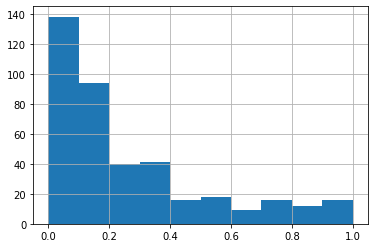

Share non-normal: 0.18453865336658354
shap_summer_z


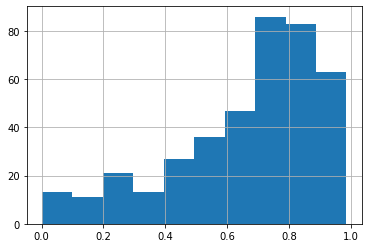

Share non-normal: 0.022443890274314215


In [44]:
for c in ['shap_lockdown_z','shap_summer_z']:
    print(c)
    deviance_df[c].hist()
    plt.show()
    print('Share non-normal:',np.mean(deviance_df[c]<.05))

In [118]:
CUT_OFF = 2.326

In [119]:
NORMAL_ONLY = False

lockdown_pd = deviance_df[deviance_df.lockdown_z >= CUT_OFF].sort_values('lockdown_z',ascending=False)
summer_pd = deviance_df[deviance_df.summer_z >= CUT_OFF].sort_values('summer_z',ascending=False)

if NORMAL_ONLY:
    lockdown_pd = lockdown_pd[lockdown_pd.shap_lockdown_z>=.05]
    summer_pd = summer_pd[summer_pd.shap_lockdown_z>=.05]

Lockdown PD:


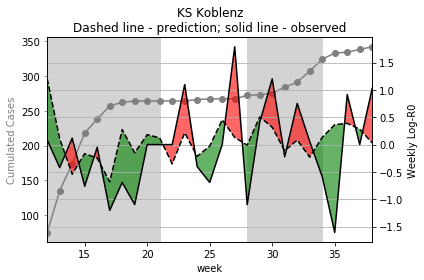

Summer PD's:


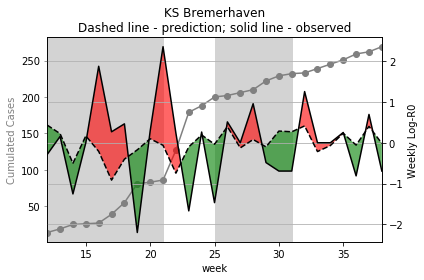

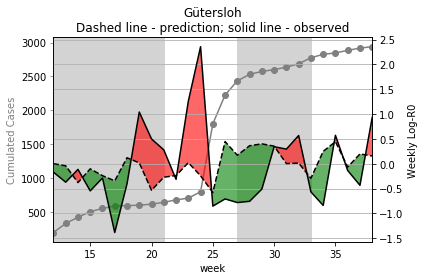

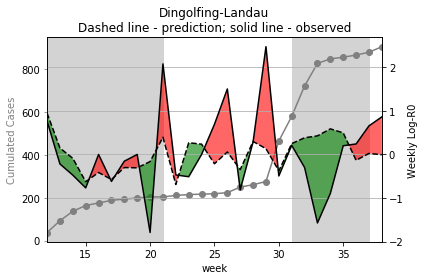

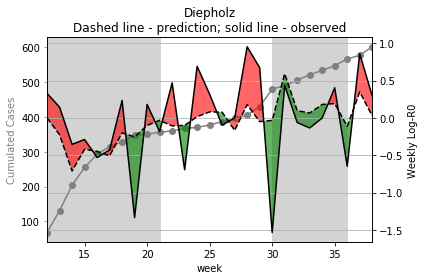

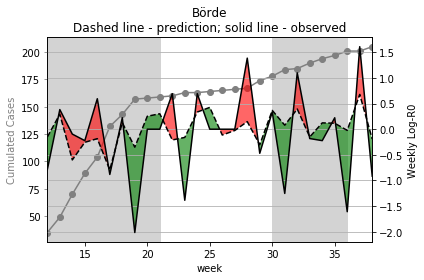

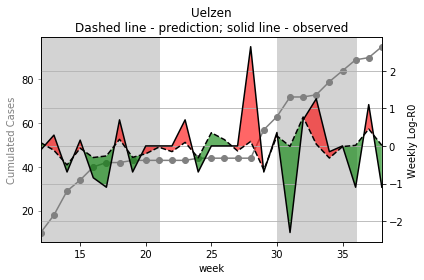

In [120]:
print('Lockdown PD:')
for d in lockdown_pd.districtId.values:
    plot_district(d)
print('Summer PD\'s:')
for d in summer_pd.districtId.values:
    plot_district(d)

For validity checking, we also include the worst and median performers for each deviance:

In [48]:
def comparators(var, worst):
    sort = deviance_df.sort_values(var, ascending=True)
    pos = 0 if worst else sort.shape[0] // 2
    return sort.districtId.iat[pos]

In [49]:
worst_ld = comparators('lockdown_z',worst=True)
worst_su = comparators('summer_z',worst=True)
medn_ld = comparators('lockdown_z',worst=False)
medn_su = comparators('summer_z',worst=False)


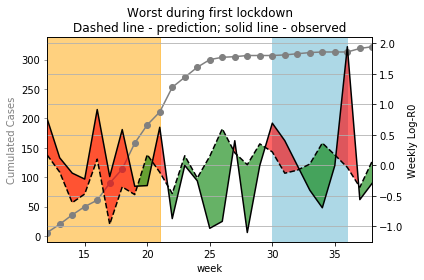

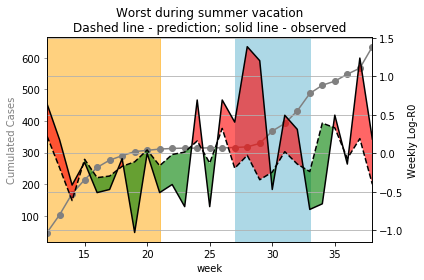

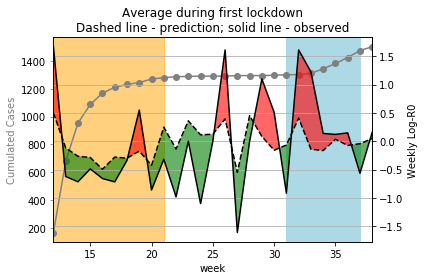

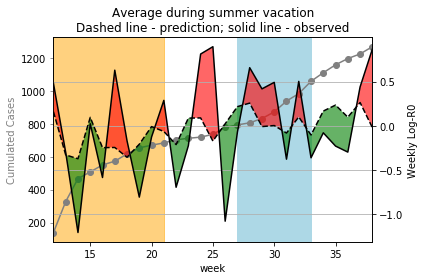

In [102]:
plot_district(worst_ld, 'Worst during first lockdown')
plot_district(worst_su, 'Worst during summer vacation')
plot_district(medn_ld, 'Average during first lockdown')
plot_district(medn_su, 'Average during summer vacation')

In [44]:
deviance_df.to_csv('deviance_df.csv',index=False)
lockdown_pd.to_csv('lockdown_pd.csv',index=False)
summer_pd.to_csv('summer_pd.csv',index=False)
all_data.to_csv('all_data_with_intervals.csv',index=False)

______________________________________________________________________________________________________________________
end of code coherence
______________________________________________________________________________________________________________________


In [45]:
all_data[all_data.district_name=='KS Jena']
deviance_df[deviance_df.districtId==16053]

,districtId,deviance_lockdown,deviance_summer,district_name,rur_z,ses_z,lockdown_z,n_peer_kernel,shapiro_p,summer_z
380,16053,0.270869,-0.31926,KS Jena,-1.161131,0.214064,1.696597,62.0,{},-1.369228


In [46]:
shapiro(deviance_df.rur_z)

(0.8756921887397766, 2.0055023729850208e-17)

In [14]:
for c in ['lockdown_z','summer_z']:
    print(c)
    for cut_off in [1.96, 2.33, 2.58]:
        above_df = deviance_df[deviance_df[c] >= cut_off]
        print('Above',cut_off,'cut-off:',above_df.shape[0],'\nincluding',
             sum(above_df.n_peer_kernel < 31),'with fewer than 30 peers and',
             sum(above_df.n_peer_kernel < 21),'with fewer than 20 peers.')

lockdown_z
Above 1.96 cut-off: 5 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.33 cut-off: 1 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.58 cut-off: 1 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
summer_z
Above 1.96 cut-off: 13 
including 2 with fewer than 30 peers and 2 with fewer than 20 peers.
Above 2.33 cut-off: 6 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.
Above 2.58 cut-off: 4 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.


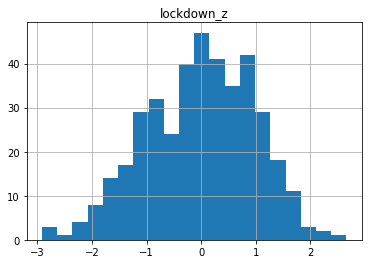

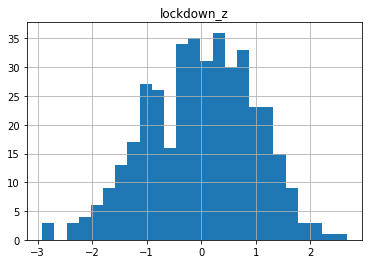

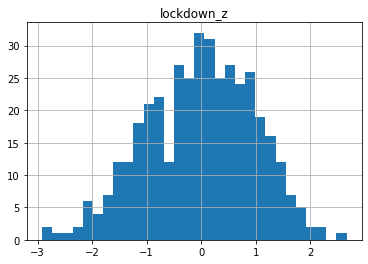

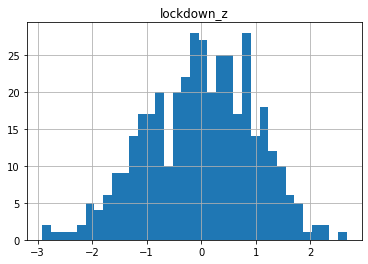

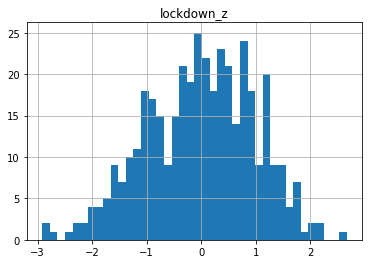

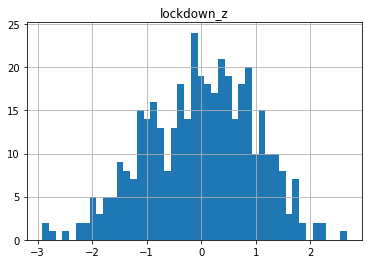

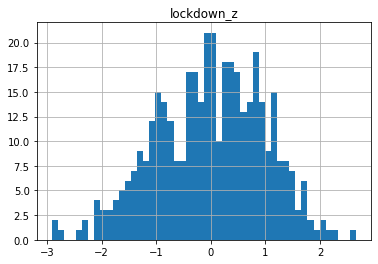

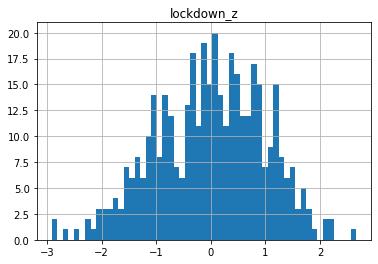

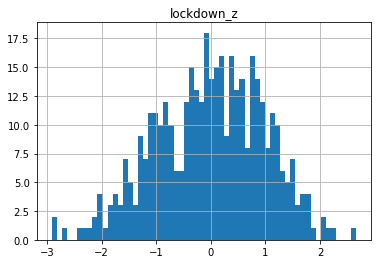

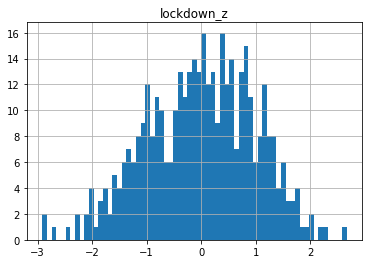

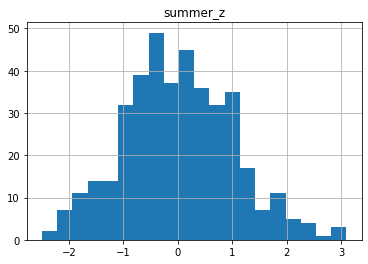

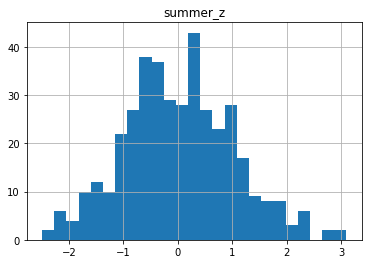

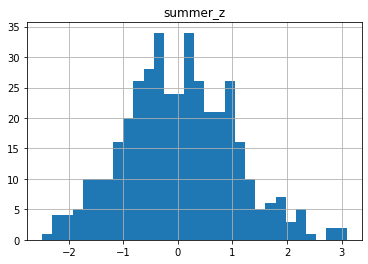

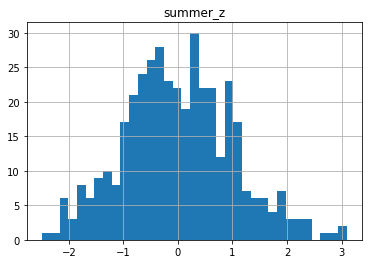

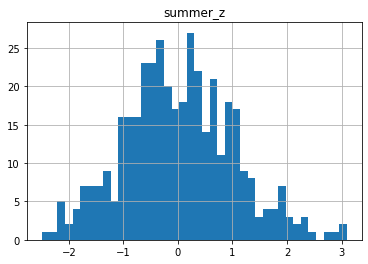

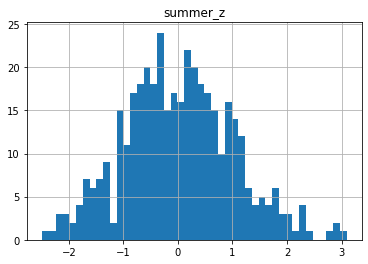

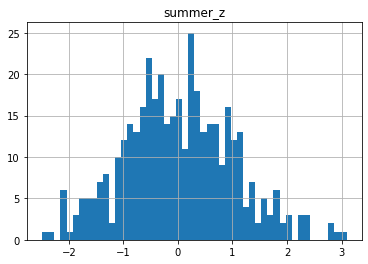

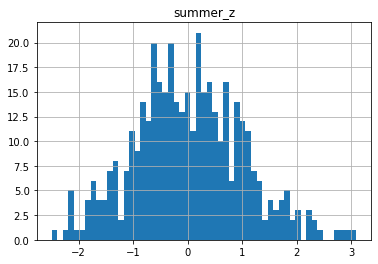

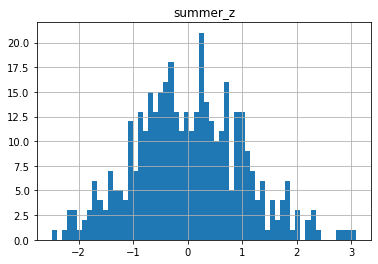

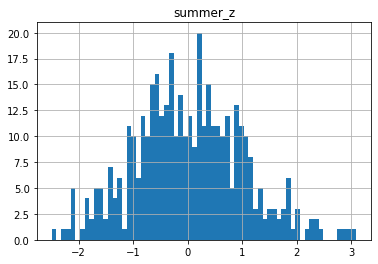

In [30]:
for c in ['lockdown_z','summer_z']:
    for x in [20+5*i for i in range(10)]:
        deviance_df[c].hist(bins=x)
        plt.title(c)
        plt.show()
#     print(deviance_df.sort_values(c,ascending=False).head(10))

Best during lockdown


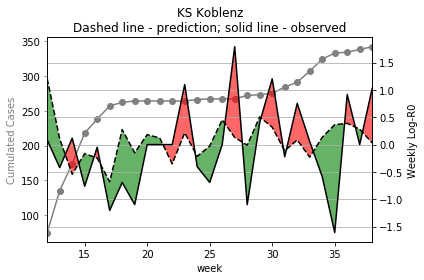

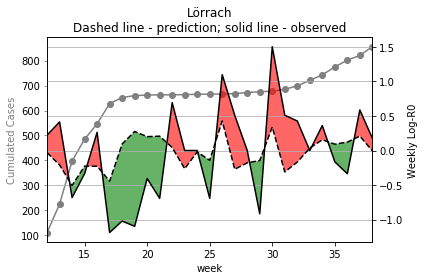

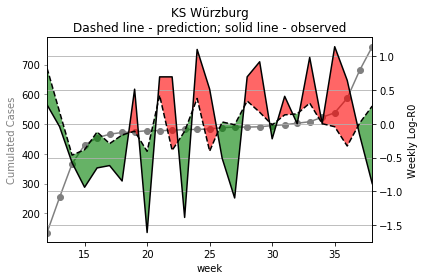

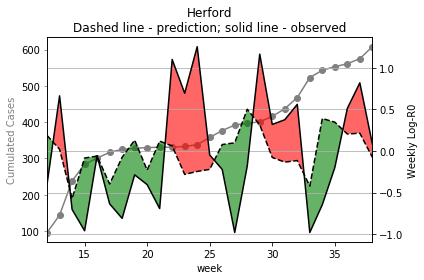

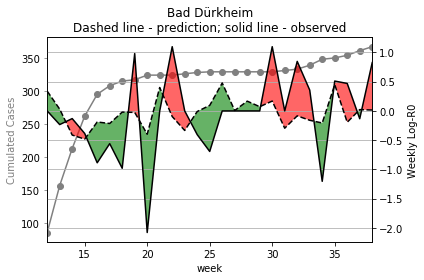

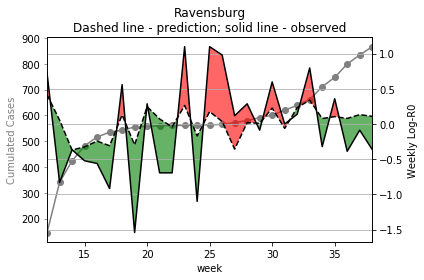

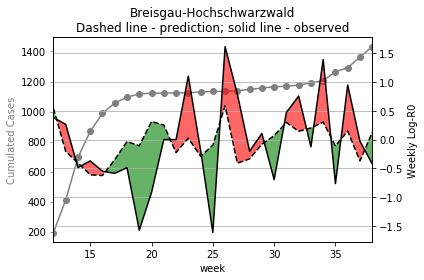

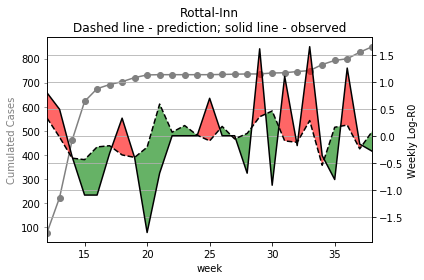

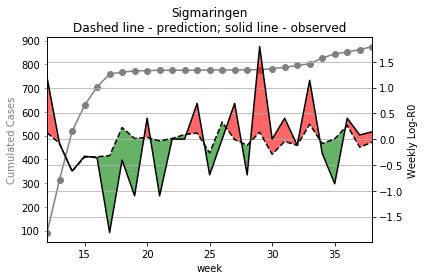

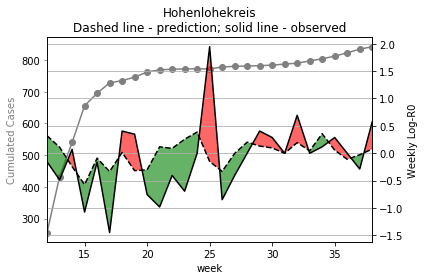

Worst during lockdown


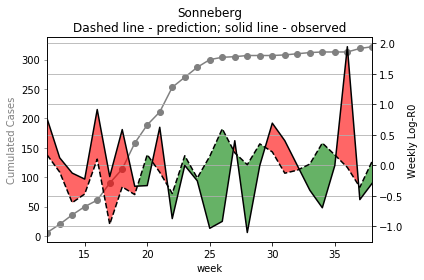

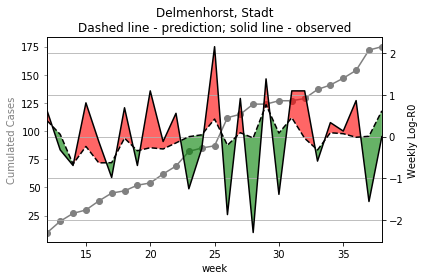

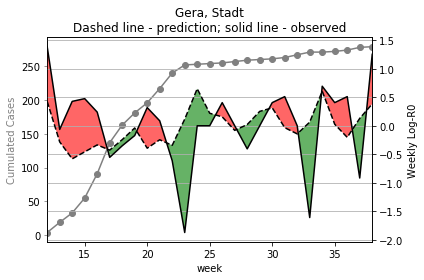

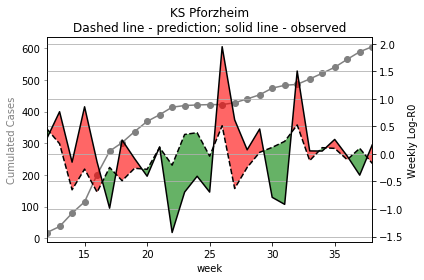

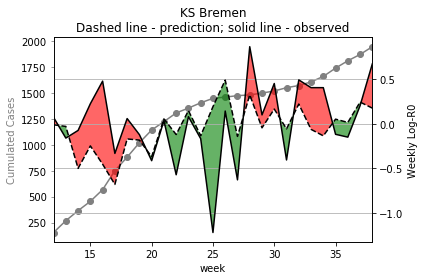

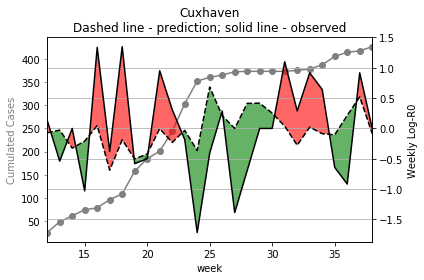

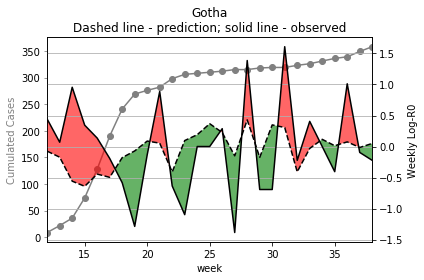

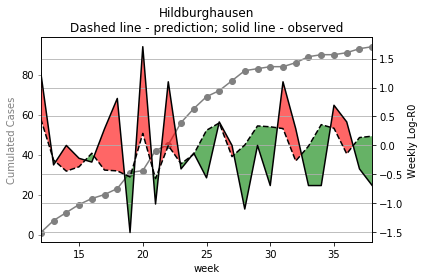

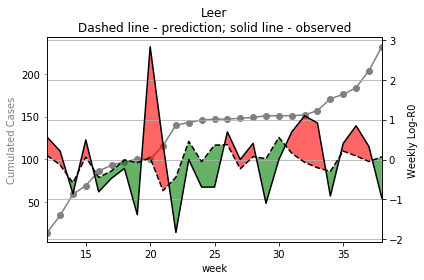

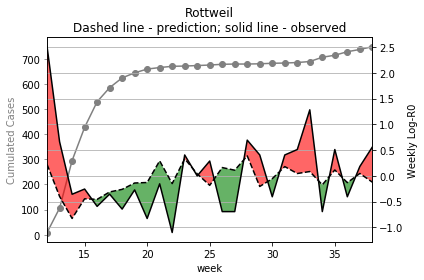

Best during summer


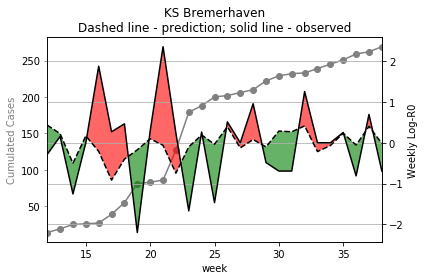

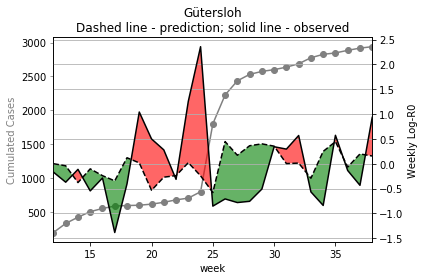

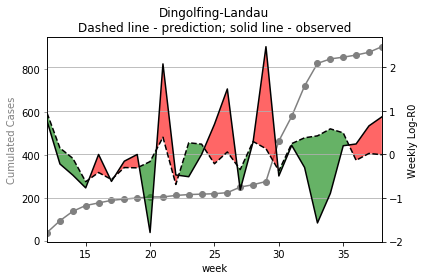

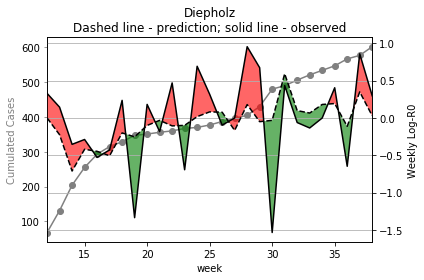

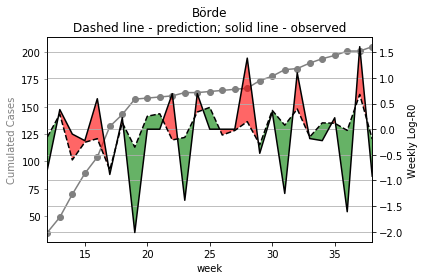

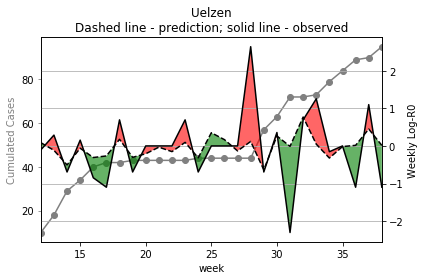

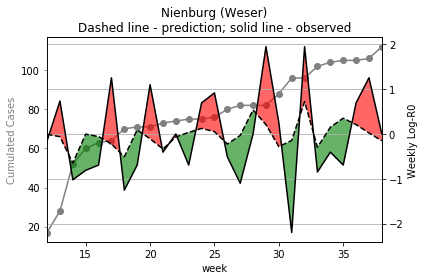

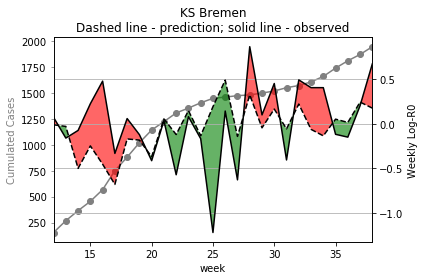

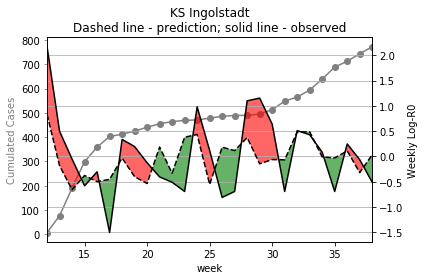

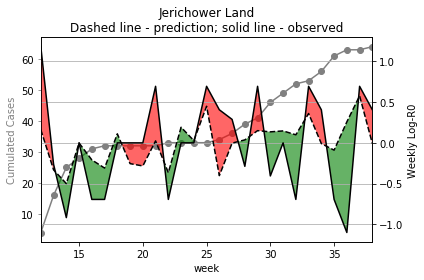

Worst during summer


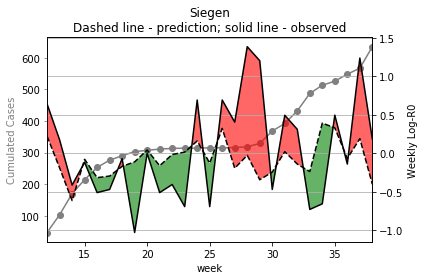

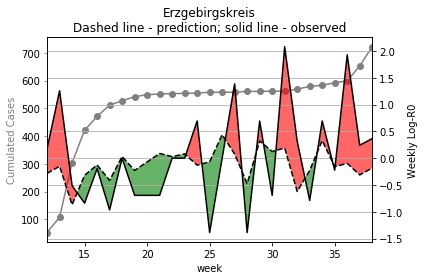

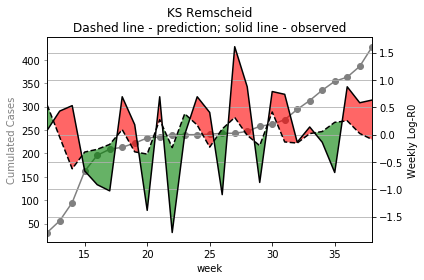

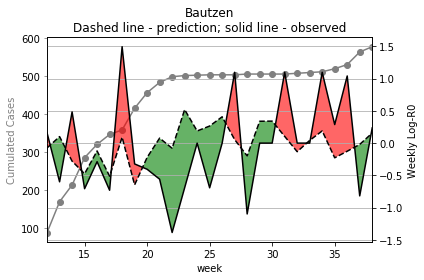

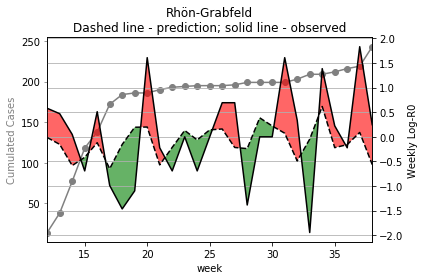

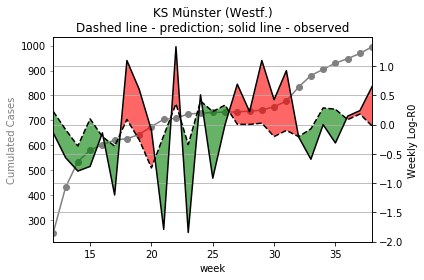

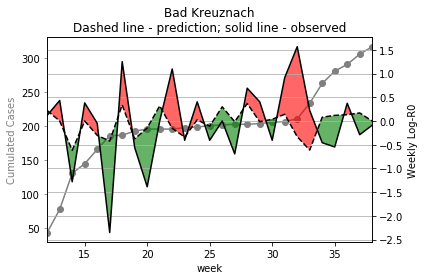

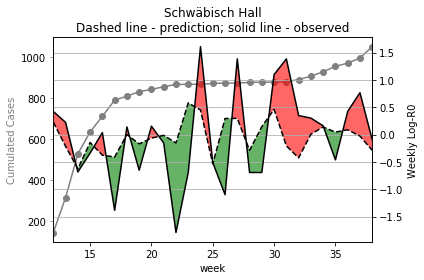

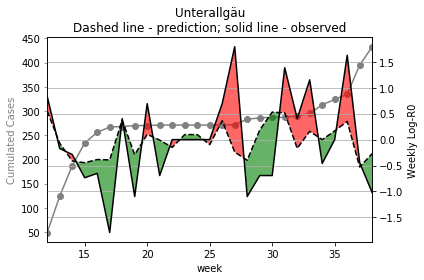

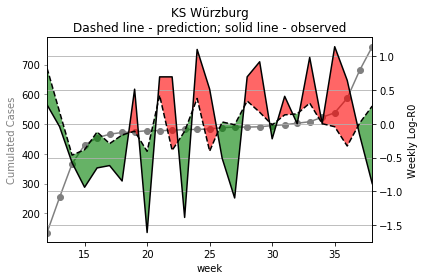

In [16]:
def top_flop_n(n, var, flop=False):
    sorted_df = deviance_df.sort_values(var,ascending=flop)
    for i in range(n):
        plot_district(sorted_df.districtId.iat[i])

N=10 

for var in ['lockdown_z','summer_z']:
    
    print('Best during',var[:-2])
    top_flop_n(N,var,flop=False)
    
    print('Worst during',var[:-2])
    top_flop_n(N,var,flop=True)

Text(0.5, 1.0, 'Summer: final PD score (x) vs raw aggregated deviance (y)')

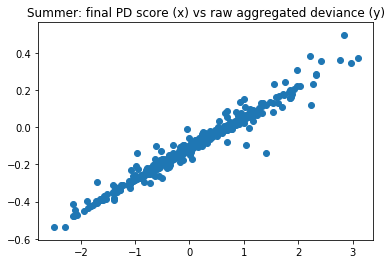

In [17]:
plt.scatter(deviance_df.summer_z,deviance_df.deviance_summer)
plt.title('Summer: final PD score (x) vs raw aggregated deviance (y)')

In [ ]:
shapiro()

Text(0.5, 1.0, 'Lockdown: final PD score (x) vs raw aggregated deviance (y)')

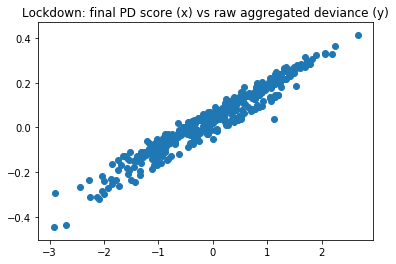

In [18]:
plt.scatter(deviance_df.lockdown_z,deviance_df.deviance_lockdown)
plt.title('Lockdown: final PD score (x) vs raw aggregated deviance (y)')

In [19]:
np.corrcoef(deviance_df.lockdown_z,deviance_df.summer_z)


array([[ 1.        , -0.11167381],
       [-0.11167381,  1.        ]])

In [20]:
data = pd.merge(all_data, deviance_df,how='outer')

In [21]:
since_first_death = data[data.AnzahlTodesfall_cumul > 0].copy()
df = pd.merge(deviance_df, since_first_death.groupby('districtId').size().reset_index()).rename(columns={0:'wsfd'})

In [22]:
np.corrcoef(df.lockdown_z, df.wsfd)

array([[1.        , 0.04367325],
       [0.04367325, 1.        ]])